In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content
!mkdir pcb-defect-detection
%cd pcb-defect-detection

!mkdir dataset
!mkdir dataset/YOLO_PCB

!mkdir dataset/YOLO_PCB/images
!mkdir dataset/YOLO_PCB/images/train
!mkdir dataset/YOLO_PCB/images/test
!mkdir dataset/YOLO_PCB/images/val

!mkdir dataset/YOLO_PCB/labels
!mkdir dataset/YOLO_PCB/labels/train
!mkdir dataset/YOLO_PCB/labels/test
!mkdir dataset/YOLO_PCB/labels/val

/content
/content/pcb-defect-detection


In [3]:
%cd /content
!cp "/content/drive/MyDrive/Colab Notebooks/VOC_PCB.zip" /content
!unzip /content/VOC_PCB.zip -d /content/pcb-defect-detection/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_05_1_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_05_2_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_05_3_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_06_1_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_06_2_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_07_1_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_07_2_600.jpg  
  inflating: /content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages/rotation_270_light_04_mouse_bite_07_3_600.jpg  
  inf

In [4]:
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [5]:
annotations = [os.path.join('/content/pcb-defect-detection/dataset/VOC_PCB/Annotations', x) for x in os.listdir('/content/pcb-defect-detection/dataset/VOC_PCB/Annotations') if x[-3:] == "xml"]

In [6]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = os.path.basename(xml_file)

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

In [7]:
print(extract_info_from_xml(annotations[0]))

{'bboxes': [{'class': 'short', 'xmin': 501, 'ymin': 23, 'xmax': 572, 'ymax': 89}, {'class': 'short', 'xmin': 495, 'ymin': 254, 'xmax': 581, 'ymax': 333}], 'filename': 'l_light_10_short_02_2_600.xml', 'image_size': (600, 600, 3)}


In [8]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {
    "missing_hole": 0,
    "mouse_bite": 1,
    "open_circuit": 2,
    "short": 3,
    "spur": 4,
    "spurious_copper": 5
}

In [9]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov_format(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("/content/pcb-defect-detection/dataset/YOLO_PCB/labels", info_dict["filename"].replace("xml", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [10]:
annotations.sort()
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov_format(info_dict)

100%|██████████| 10668/10668 [00:02<00:00, 4722.96it/s]


In [11]:
annotations = [os.path.join('/content/pcb-defect-detection/dataset/YOLO_PCB/labels', x) for x in os.listdir('/content/pcb-defect-detection/dataset/YOLO_PCB/labels') if x[-3:] == "txt"]

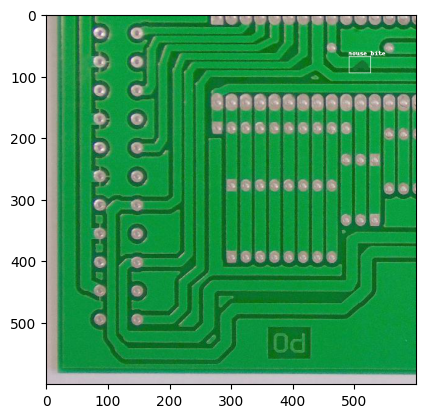

In [12]:
# random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("YOLO_PCB", "VOC_PCB").replace("labels", "JPEGImages").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [13]:
images = [os.path.join('/content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages', x) for x in os.listdir('/content/pcb-defect-detection/dataset/VOC_PCB/JPEGImages') if x[-3:] == "jpg"]
annotations = [os.path.join('/content/pcb-defect-detection/dataset/YOLO_PCB/labels', x) for x in os.listdir('/content/pcb-defect-detection/dataset/YOLO_PCB/labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# images = images[:1000]
# annotations = annotations[:1000]

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2, random_state=1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=1)

In [14]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/pcb-defect-detection/dataset/YOLO_PCB/images/train')
move_files_to_folder(val_images, '/content/pcb-defect-detection/dataset/YOLO_PCB/images/val')
move_files_to_folder(test_images, '/content/pcb-defect-detection/dataset/YOLO_PCB/images/test')
move_files_to_folder(train_annotations, '/content/pcb-defect-detection/dataset/YOLO_PCB/labels/train')
move_files_to_folder(val_annotations, '/content/pcb-defect-detection/dataset/YOLO_PCB/labels/val')
move_files_to_folder(test_annotations, '/content/pcb-defect-detection/dataset/YOLO_PCB/labels/test')

In [3]:
%cd /content/pcb-defect-detection

/content/pcb-defect-detection


In [4]:
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 16000, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 16000 (delta 103), reused 120 (delta 76), pack-reused 15831
Receiving objects: 100% (16000/16000), 14.65 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (10972/10972), done.


In [5]:
%cd /content/pcb-defect-detection/yolov5
!pip install -r requirements.txt  # install
!cp "/content/drive/MyDrive/Colab Notebooks/PCBDefect.yaml" /content/pcb-defect-detection/yolov5/data
!cp "/content/drive/MyDrive/Colab Notebooks/hyp.scratch-PCBDefect.yaml" /content/pcb-defect-detection/yolov5/data/hyps

/content/pcb-defect-detection/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [18]:
!python train.py --img 600 --batch 32 --epochs 20 --data PCBDefect.yaml --hyp hyp.scratch-PCBDefect.yaml --weights yolov5m.pt --workers 2 --project "/content/drive/MyDrive/Colab Notebooks/pcb-defect"

train: weights=yolov5m.pt, cfg=, data=PCBDefect.yaml, hyp=hyp.scratch-PCBDefect.yaml, epochs=20, batch_size=32, imgsz=600, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=/content/drive/MyDrive/Colab Notebooks/pcb-defect, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.0001, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=

In [22]:
!python val.py --weights "/content/drive/MyDrive/Colab Notebooks/pcb-defect/exp9/weights/best.pt" --data PCBDefect.yaml --img 600 --half --project "/content/drive/MyDrive/Colab Notebooks/pcb-defect"

val: data=/content/pcb-defect-detection/yolov5/data/PCBDefect.yaml, weights=['/content/drive/MyDrive/Colab Notebooks/pcb-defect/exp9/weights/best.pt'], batch_size=32, imgsz=600, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/drive/MyDrive/Colab Notebooks/pcb-defect, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20873139 parameters, 0 gradients, 47.9 GFLOPs
WARNING ⚠️ --img-size 600 must be multiple of max stride 32, updating to 608
val: Scanning /content/pcb-defect-detection/dataset/YOLO_PCB/labels/val.cache... 1067 images, 0 backgrounds, 0 corrupt: 100% 1067/1067 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 34/34 [00:22<00:00,

In [21]:
!python detect.py --weights "/content/drive/MyDrive/Colab Notebooks/pcb-defect/exp9/weights/best.pt" --img 600 --conf 0.25 --source "/content/pcb-defect-detection/dataset/YOLO_PCB/images/test" --project "/content/drive/MyDrive/Colab Notebooks/pcb-defect"

detect: weights=['/content/drive/MyDrive/Colab Notebooks/pcb-defect/exp9/weights/best.pt'], source=/content/pcb-defect-detection/dataset/YOLO_PCB/images/test, data=data/coco128.yaml, imgsz=[600, 600], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Colab Notebooks/pcb-defect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20873139 parameters, 0 gradients, 47.9 GFLOPs
WARNING ⚠️ --img-size [600, 600] must be multiple of max stride 32, updating to [608, 608]
image 1/1067 /content/pcb-defect-detection/dataset/YOLO_PCB/images/test/l_light_01_missing_hole_03_2_600.jpg: 608x608 1 missing_hole, 25.

In [9]:
!python detect.py --weights "/content/drive/MyDrive/Colab Notebooks/pcb-defect/train/weights/best.pt"  --img 600  --conf 0.25  --source "/content/10_missing_hole_04.jpg"  --project "/content/drive/MyDrive/Colab Notebooks/pcb-defect-1"

detect: weights=['/content/drive/MyDrive/Colab Notebooks/pcb-defect/train/weights/best.pt'], source=/content/10_missing_hole_04.jpg, data=data/coco128.yaml, imgsz=[600, 600], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Colab Notebooks/pcb-defect-1, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-186-g0acc5cf Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20873139 parameters, 0 gradients, 47.9 GFLOPs
WARNING ⚠️ --img-size [600, 600] must be multiple of max stride 32, updating to [608, 608]
image 1/1 /content/10_missing_hole_04.jpg: 576x608 5 missing_holes, 74.9ms
Speed: 2.2ms pre-process, 74.9ms inference, 19.2ms NMS per image at shape (1, 3, 608, 